In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from utils import print_metrics, plot_forecast, backtest, Dataset, TimeseriesExperiment

import pickle

import os

In [2]:
def get_series_from_dataframe(dataframe, column_name):
  # consts 
  TRAIN_DAYS = 60
  PREDICTION_HOURS = 24

  s = TimeSeries.from_dataframe(dataframe, time_col='ds', value_cols=column_name, freq=None, fill_missing_dates=True)
  s = s.slice_n_points_before(s.end_time(), TRAIN_DAYS*24*60)
  s = s.resample('1h', method='pad')

  ma_filter = MovingAverageFilter(12)
  s = ma_filter.filter(s)

  # save to txt file for layer use
  s.to_csv('data/electricity.txt')

  return s

def get_series_from_dataframe_xgboost(df: pd.DataFrame) -> TimeSeries:
  df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce').astype(np.float32)
  df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce').astype(np.float32)
  df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce').astype(np.float32)
  df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce').astype(np.float32)
  df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce').astype(np.float32)
  df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce').astype(np.float32)
  df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce').astype(np.float32)

  # fill NA values with the previous value
  df = df.ffill()

  return get_series_from_dataframe(df, 'Global_active_power')

def load_electricity_data():
  # try to read TimeSeries object from electricity.txt file
  if os.path.exists('data/electricity.txt'):
    s = TimeSeries.from_csv('data/electricity.txt', time_col='ds', value_cols='rolling_mean_12_Global_active_power')
    return s

  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})

  return get_series_from_dataframe_xgboost(df)


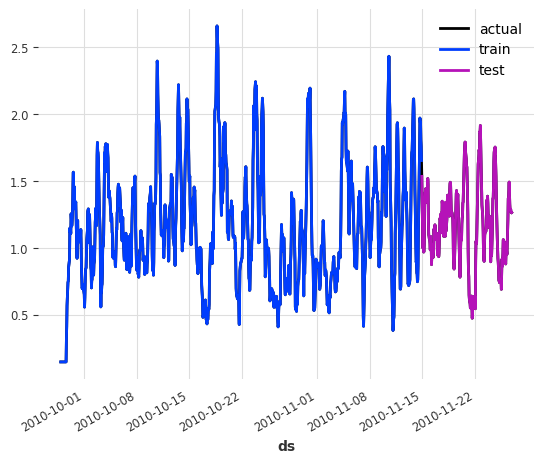

In [3]:
XGBoost_dataset = Dataset(load_electricity_data(), 'electricity')

In [4]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
  lags=24 * 7 * 6,
  output_chunk_length=100
)

xgb_experiment = TimeseriesExperiment(xgb_model, XGBoost_dataset, { 'lags': [24 * 7 * 6], 'output_chunk_length': [100] }, use_pretrained_model=True)

In [5]:
xgb_experiment.run()

{'mape': 41.92541534152369,
 'mse': 0.24497868300758638,
 'rmse': 0.4949532129480385,
 'mae': 0.37697521400064543,
 'model': 'XGBModel',
 'forecast_horizon': 3,
 'dataset': 'electricity',
 'experiment_time': 1714736338.0482519,
 'parameters': OrderedDict([('lags', 1008),
              ('lags_past_covariates', None),
              ('lags_future_covariates', None),
              ('output_chunk_length', 100),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('device', 'cuda')])}